<a href="https://colab.research.google.com/github/Mirilh/Red-Neuronal-Clasificacion-Ropa/blob/main/Modelo_clasificacion_ropa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Red neuronal de clasificacion de ropa.
- Red neuronal convolucional usada para la clasificación.
- Con dos capas ocultas.
- Funciones de activación.
COMO SERÁ LA RED:
Las imagenes las detecta clasificando por colores los pixeles de una imagen. Para que no sea tan grande le bajaremos la resolucion y dejaremos las imagenes con 28*28 pixeles blanco y negro (entre estos dos varemos de colores cada uno tiene un número B 255 - N 0 ) que harán que en total haya 784, este será el numero de neuronas de entrada. 
- 784 neuronas de entrada
- 10 neuronas de salida: tipo de imagen que va a poder clasificar (camiseta, pantalon, etc...)
- 2 capas ocultas -> 50 neuronas cada
- Usaremos un dataset de Zalando (60000 datos / imagenas para entrenar - 10000 para testear)

In [260]:
# Importar tensorflow , matplotlib (visualización) y  math , np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
import numpy as np

In [261]:
# Indicamos el Datasheet a descargar
datos, metadatos = tfds.load('fashion_mnist', as_supervised = True, with_info = True )

#### Argumentos usados de tfds.load:
###### - as_supervised: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.
###### - with_info: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo), the latter containing the info associated with the builder.

In [262]:
# Vemos la info que nos trae el Dataset
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author  

In [263]:
# Vemos que por ejemplo tiene 6k datos para entrenar y 1k para testear
# Por lo que pongamos cada uno en una variable para utilizarlos
train , test = datos['train'], datos['test']

In [264]:
# Los metadatos tambien tran las categorias que existen 
clothes = metadatos.features['label'].names
clothes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Como son las imagenes del dataset y que valores vienen sobre ellos: 

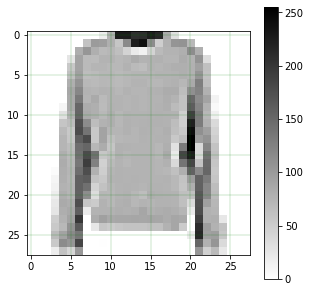

In [265]:
for image, label in train.take(1):  #En los metadatos nos dan :  supervised_keys=('image', 'label')
  break

image = image.numpy().reshape((28,28)) #Redimensionamos
plt.figure(figsize=(5,5))
plt.imshow(image, cmap=plt.cm.binary) #Que muestre la imagen, con un mapa de colores binarios
plt.colorbar() #Que muestre a barra de gradiente de color
plt.grid(color='g', linestyle='-', linewidth=0.2) #cuadricula
plt.show()

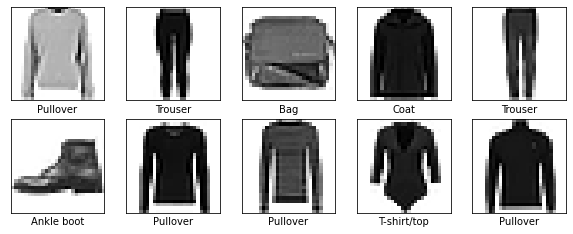

In [266]:
# Le pedimos varias imágenes y que tambien devuelva la etiqueta con la que fueron clasificadas
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train.take(10)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1) #tamaño y Que se vayan poniendo los 'graficos' a continuación segun pasan por el bucle
  plt.xticks([]) #Que no se muestren valores en x e y 
  plt.yticks([])
  plt.grid(False) #Sin cuadricula
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(clothes[label]) #Etiqueta de cada imagen segun el dataset
plt.show()

NORMALIZAMOS LOS DATOS para poder entrenar a la red: 
- Para normalizar los datos y todas las entradas tienen que estar entre 0 y 1, y ahora estan colocados de 0-255 por ser el baremo en el que se mueven los pixeles de las imagenes de B-N
- Normalizaremos dividiendo cada pixel entre 255

In [267]:
# Cuando entrenamos una red queremos normalizar los datos que todas las entradas sean entre 0 y 1, y ahora estan colocados de 0-255 por ser el varemo en el que se mueven los pixeles B-N
# Asi que normalizaremos dividiendo cada pixel entre 255
def normalizar(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255 
  return images, labels

# Llamamos a la funcion con los datos de entreno y test
train = train.map(normalizar)
test = test.map(normalizar)


In [268]:
# Agregamos al caché (Usar memoria en vez de disco hará que el entrenamiento sea más rápido)
train = train.cache()
test = test.cache()

MODELO:
- Definiremos la capa de entrada manualmente usando una de tipo flatten, los datos de entrada vienen  28x28 , asi que se lo decimos y la pasa a 1 dimension, con 784 neuronas donde se recibira cada pixel. Y pixel normalizado 1 B-N
- Ademas añadimos las dos capas ocultas densas con 50 neuronas cada una y una activación relu
- La capa de salina con 10 neuronas (tipos de ropa), con la funcion Softmax - usado en redes de clasificacion. Se usa porque valora cada output con un valor en función de lo que haya entendido que es dando valores cuya suma máxima es 1 en funcion de su parecido con la imagen dice: pantalones 0.8, camiseta 0.1 , sandalias 0,... siendo la suma entre todas las salidas siempre 1 y devolviendo como resultado el valor de salida que más se aceque a 1 -> pantalones

In [269]:
#Modelo
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28,1)),
    tf.keras.layers.Dense(50, activation = tf.nn.relu),
    tf.keras.layers.Dense(50, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

In [270]:
#Compilar
modelo.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), #Perdida que se usa en las redes de clasificación
    metrics = ['accuracy']
)

In [271]:
#Datos para entreno y testeo
num_train = metadatos.splits['train'].num_examples
num_test = metadatos.splits['test'].num_examples
print(f'Datos disponibles para entrenar: {num_train}\nDatos disponibles para testear: {num_test}')

Datos disponibles para entrenar: 60000
Datos disponibles para testear: 10000


In [272]:
#Lotes : Tenemos un dataset con 70K imagenes para hacer que la red entrene más rápido dividiremos el trabajo en lotes de 32 datos
#Entrenamiento aleatorio que no siga el orden del dataset
size = 40
train = train.repeat().shuffle(num_train).batch(size)
test = test.batch(size)

In [273]:
modelo_entrenado = modelo.fit(train, epochs = 4, steps_per_epoch = math.ceil(num_train/size)) #Nº vueltas

Epoch 1/4
1500/1500 [==============================] - 15s 5ms/step - loss: 0.5354 - accuracy: 0.8140
Epoch 2/4
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3921 - accuracy: 0.8596
Epoch 3/4
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8711
Epoch 4/4
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3306 - accuracy: 0.8786


In [274]:
...
# list all data in history
print(modelo_entrenado.history.keys())

dict_keys(['loss', 'accuracy'])


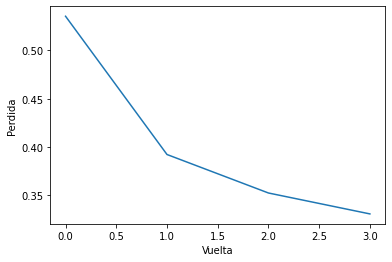

In [275]:
#Vamos a ver la perdida en cada vuelta para ver donde el modelo ajusta ya bien 
plt.xlabel('Vuelta')
plt.ylabel('Perdida')
plt.plot(modelo_entrenado.history["loss"])

#### Testear el modelo
- Vamos a comprobar si realmente el modelo tiene en torno a un 90% de precisión pasandole datos usados para el testeo y viendo si corresponde realmente con lo que debería ser
- Crearemos un grafico que muestre el valor que da a cada salida y si finalmente se equivoca.

2/2 [==============================] - 0s 5ms/step


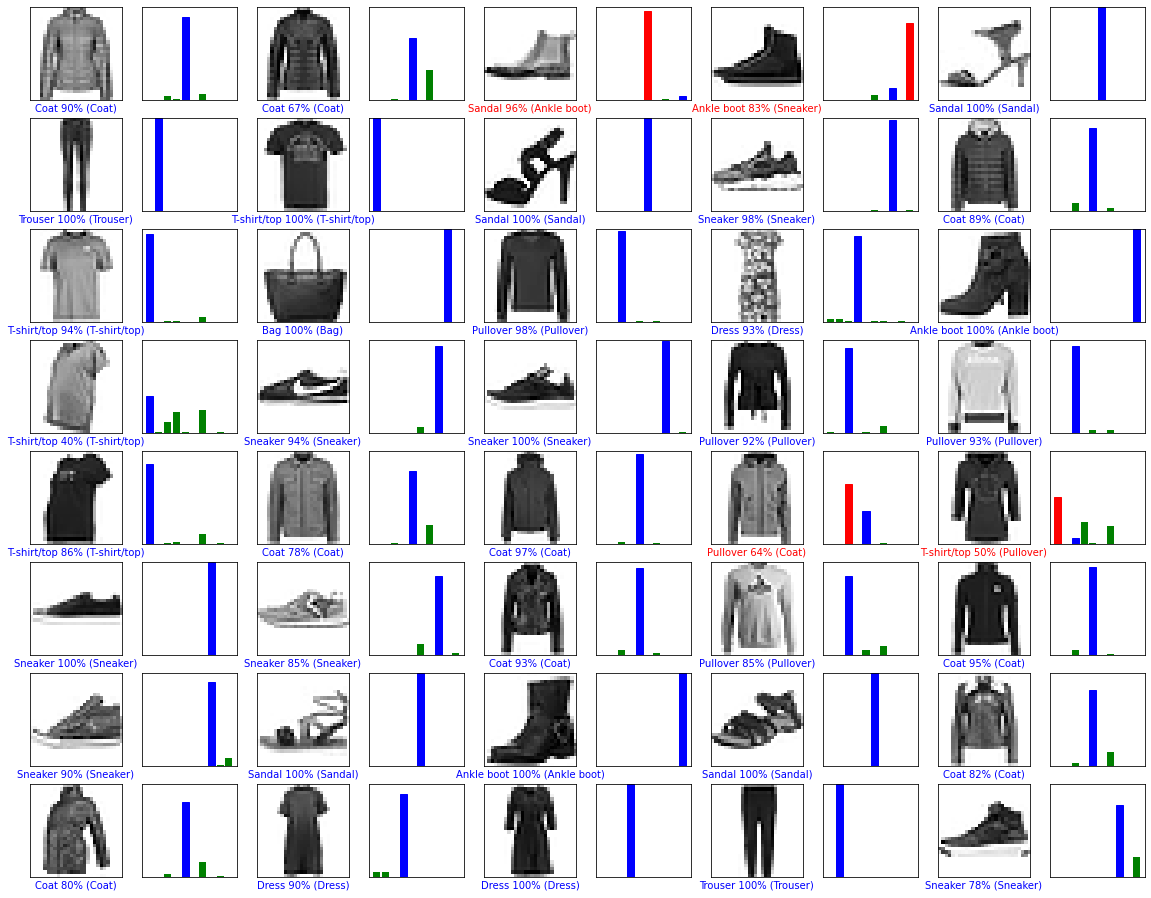

In [282]:
for test_images, test_labels in test.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  modelo_prediccion = modelo.predict(test_images)

def grafico_img(i, prediction, real, imagenes):
  prediction, real_label, img = prediction[i], real[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...,0], cmap = plt.cm.binary)

  predict_label = np.argmax(prediction)
  if predict_label == real_label:
    color = 'b'
  else:
    color = 'r'
  
  plt.xlabel((f"{clothes[predict_label]} {100*np.max(prediction):2.0f}% ({clothes[real_label]})"), color = color)

def grafico_bar (i, prediction, real):
  prediction , real_label = prediction[i], real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), prediction, color ='g')
  plt.ylim([0,1])
  predict_label = np.argmax(prediction)

  grafica[predict_label].set_color('r')
  grafica[real_label].set_color('b')

rows = 8
columns = 5
num_img = rows*columns
plt.figure(figsize = (2*2*columns, 2*rows))

for i in range(num_img):
  plt.subplot(rows, 2*columns , 2*i+1)
  grafico_img(i, modelo_prediccion, test_labels, test_images ) #Le paso los argumentos del modelo testeado arriba

  plt.subplot(rows, 2*columns , 2*i+2)
  grafico_bar(i, modelo_prediccion, test_labels )

